# BERT (Stopwords REMOVED)

This version of BERT removed stopwords, and is using a max token length of 100 to keep runtimes sane

In [1]:
# following this tutorial: https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/
# Check this out as well: https://www.tensorflow.org/text/tutorials/classify_text_with_bert

import re
import tqdm
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import transformers
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

/Users/maxx/miniconda3/envs/py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])
df.head()

,labels,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['text'] = df['text'].apply(clean_text)

In [20]:
from sklearn.model_selection import train_test_split
# transform y into 1 hot vectors
y = pd.get_dummies(df["labels"])
y = np.array(y)
y_test = pd.get_dummies(test_df["labels"])
y_test = np.array(y_test)

X_test = test_df["text"]
X_train, X_val, y_train, y_val = train_test_split(df['text'],y, stratify=df['labels'])
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(36640,) (36640, 4)
(12214,) (12214, 4)


42050    copyright 2009 washington post first big laugh...
15021    mother incredible message sons teacher lesson ...
30248                 taxing rich fix deficitlearn liberty
45620    european union thursday said agreed sign free ...
38464    plan x darpas new project seeks make cyberwarf...
                               ...                        
44648    indonesian government buy 14 percent shares va...
9523     republican vice presidential nominee sarah pal...
34450    9 steps take prepare perfect storm civil unres...
23426    earthquake near san francisco start shaking ca...
11988    openair preacher brother sam hilson rescued 30...
Name: text, Length: 36640, dtype: object

In [33]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train.values.reshape(-1,1), y_train)
# Check the number of records after under sampling
print(X_train_rus.shape)
print('training: ', y_train.sum(axis=0))
print('training rus: ', y_train_rus.sum(axis=0))
X_train_rus = X_train_rus.reshape(X_train_rus.shape[0],)

(20828, 1)
training:  [10535  5207 13402  7496]
training rus:  [5207 5207 5207 5207]


array(['touting robust traffic par popular games representatives las vegas bellagio resort said thursday casino enjoying steady profits new slot machine explicitly guarantees players lose lose dollar machines 48 reportedly installed casinos main gaming floor several weeks ago feature large prominent placard bolted front panel unambiguously notifies players six different languages absolutely chance receiving kind payout incredibly pleased theres demand slot makes winning utterly impossible said casino representative kelly ambrose emphasizing slot machines traditionally offered longer odds others lose dollar first remove success gameplay entirely weve seen people genuinely excited inserting dollar bill losing inserting another dollar bill happy guests bellagio added ambrose according casino sources new machines features simple design consisting plain gray outer casing sidemounted handle pulled immediately informs player lost game flashing word loser screen sounding loud buzzer noticeably

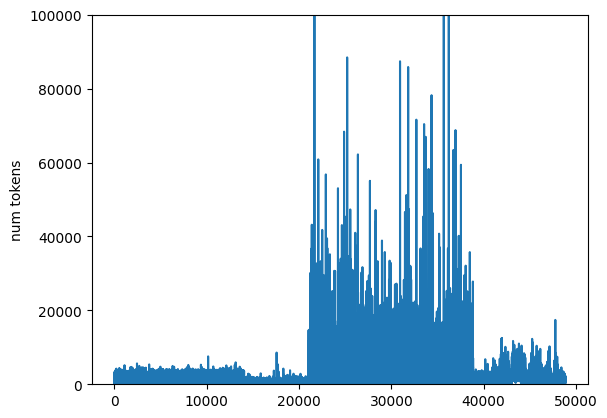

In [33]:
df['text'].apply(len).plot(ylabel="num tokens", ylim=(0,100000))

# we can choose roughly 40000 as a maxlen
MAX_LEN = 512 # not in use

In [34]:
import tensorflow_hub as hub
from bert import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-06 03:18:11.300579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 03:18:11.301084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [36]:
# optimizer = Adam(
#     learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
#     epsilon=1e-08,
#     decay=0.01,
#     clipnorm=1.0)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(4, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=[
        "CategoricalCrossentropy",
        tf.keras.metrics.Precision(), 
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
        tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
    ])
    
    return model

In [37]:
max_len = 100
print("Encoding train")
train_input = bert_encode(X_train_rus, tokenizer, max_len=max_len)
print("Encoding validation")
val_input = bert_encode(X_val, tokenizer, max_len=max_len)
print("Encoding test")
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
print("Done encoding")
train_labels = y_train_rus

Encoding train
Encoding validation
Encoding test
Done encoding


In [38]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 100, 768)]                'input_mask[0][0]',         

/Users/maxx/miniconda3/envs/py3.9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('bert_model.h5', monitor='val_f1_score_macro', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score_macro', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    validation_data=[val_input, y_val]
)

Epoch 1/3


2023-04-06 03:20:04.179981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-06 03:20:10.154493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


651/651 [==============================] - ETA: 0s - loss: 0.4746 - categorical_crossentropy: 0.4746 - precision: 0.8946 - recall: 0.7528 - auc: 0.9620 - f1_score_micro: 0.8180 - f1_score_macro: 0.8177 

2023-04-06 10:57:45.636089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_f1_score_macro improved from inf to 0.93200, saving model to bert_model.h5
651/651 [==============================] - 28260s 43s/step - loss: 0.4746 - categorical_crossentropy: 0.4746 - precision: 0.8946 - recall: 0.7528 - auc: 0.9620 - f1_score_micro: 0.8180 - f1_score_macro: 0.8177 - val_loss: 0.1996 - val_categorical_crossentropy: 0.1996 - val_precision: 0.9401 - val_recall: 0.9338 - val_auc: 0.9919 - val_f1_score_micro: 0.9361 - val_f1_score_macro: 0.9320
Epoch 2/3
651/651 [==============================] - ETA: 0s - loss: 0.1240 - categorical_crossentropy: 0.1240 - precision: 0.9650 - recall: 0.9565 - auc: 0.9962 - f1_score_micro: 0.9599 - f1_score_macro: 0.9599
Epoch 2: val_f1_score_macro did not improve from 0.93200
651/651 [==============================] - 5223s 8s/step - loss: 0.1240 - categorical_crossentropy: 0.1240 - precision: 0.9650 - recall: 0.9565 - auc: 0.9962 - f1_score_micro: 0.9599 - f1_score_macro: 0.9599 - val_loss: 0.0982 - val_categorical_crossent

In [40]:
model.save('bert_model_2')

NotFoundError: /var/folders/68/c2vd8ndn12s0ky3brj493wzr0000gn/T/tfhub_modules/ce53fe6769d2ac3a260e92555120c54e1aecbea6/assets/vocab.txt; No such file or directory

In [41]:
results = model.evaluate(val_input, y_val, batch_size=32)
print('Test loss:', results[0])
print('Test categorical_accuracy:', results[1])
print('Test precision:', results[2])
print('Test recall:', results[3])
print('Test auc:', results[4])
print('Test F1 (micro):', results[5])
print('Test F1 (macro):', results[6])

382/382 [==============================] - 826s 2s/step - loss: 0.0925 - categorical_crossentropy: 0.0925 - precision: 0.9737 - recall: 0.9717 - auc: 0.9967 - f1_score_micro: 0.9727 - f1_score_macro: 0.9706
Test loss: 0.09253252297639847
Test categorical_accuracy: 0.09253252297639847
Test precision: 0.9736648201942444
Test recall: 0.9716718196868896
Test auc: 0.9966537356376648
Test F1 (micro): 0.9727362394332886
Test F1 (macro): 0.9706491827964783


In [42]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

START predict


2023-04-06 16:02:25.000275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 199s 2s/step
DONE predict
START evaluate
94/94 [==============================] - 199s 2s/step - loss: 1.4252 - categorical_crossentropy: 1.4252 - precision: 0.5786 - recall: 0.5310 - auc: 0.8140 - f1_score_micro: 0.5587 - f1_score_macro: 0.5441
Test loss: 1.4252047538757324
Test categorical_accuracy: 1.4252047538757324
Test precision: 0.5786414742469788
Test recall: 0.531000018119812
Test auc: 0.8139796257019043
Test F1 (micro): 0.5586666464805603
Test F1 (macro): 0.544059693813324


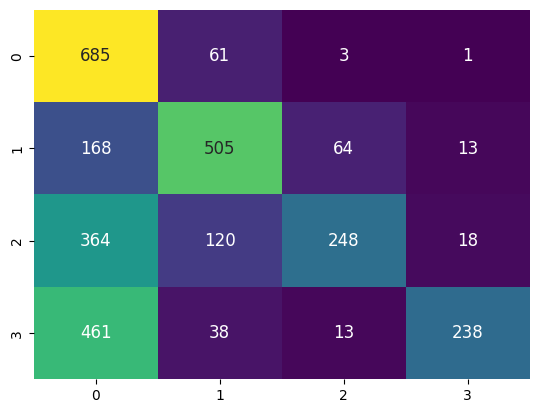

In [43]:

# predict
print("START predict")
test_predictions = model.predict(test_input)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(test_input, y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(y_test, axis=1), test_result)
